<a href="https://colab.research.google.com/github/nisarahamedk/Kaggle_Notebooks/blob/master/melanoma_classification/01_combine_context_and_external_data_to_tfrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Combine context + external data into TFRecords for TPU training.

#### GCSFS for accessing Kaggle GCS bucket directly

In [1]:
!pip install gcsfs

### Imports

In [0]:
import gcsfs
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm

In [0]:
# isic 2020
GCS_PATH_ORIG = "gs://kds-c89313da1d85616eec461ab327fed61e1335defb486fb7729cf897b1"
GCS_PATH_ORIG_TFR = GCS_PATH_ORIG + "/tfrecords"
GCS_PATH_ORIG_TRAIN_CSV = GCS_PATH_ORIG + "/train.csv"
GCS_PATH_ORIG_TEST_CSV = GCS_PATH_ORIG + "/test.csv"

# isic 2019
GCS_PATH_EXT = "gs://kds-5fd75db31a73c90ab8286af79b4045444797930ff7d68496817c995f"
GCS_PATH_EXT_TRAIN_CSV = GCS_PATH_EXT + "/ISIC_2019_Training_GroundTruth.csv"
GCS_PATH_EXT_TRAIN_META = GCS_PATH_EXT + "/ISIC_2019_Training_Metadata.csv"

### ISIC 2020 Original Data

In [19]:
orig_train_df = pd.read_csv(GCS_PATH_ORIG_TRAIN_CSV)
orig_train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [23]:
orig_test_df = pd.read_csv(GCS_PATH_ORIG_TEST_CSV)
orig_test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


Above the tabular features we have.  

Actual images in tfrecord format (also available in jpeg)

In [24]:
print(tf.io.gfile.listdir(GCS_PATH_ORIG_TFR))

['test00-687.tfrec', 'test01-687.tfrec', 'test02-687.tfrec', 'test03-687.tfrec', 'test04-687.tfrec', 'test05-687.tfrec', 'test06-687.tfrec', 'test07-687.tfrec', 'test08-687.tfrec', 'test09-687.tfrec', 'test10-687.tfrec', 'test11-687.tfrec', 'test12-687.tfrec', 'test13-687.tfrec', 'test14-687.tfrec', 'test15-677.tfrec', 'train00-2071.tfrec', 'train01-2071.tfrec', 'train02-2071.tfrec', 'train03-2071.tfrec', 'train04-2071.tfrec', 'train05-2071.tfrec', 'train06-2071.tfrec', 'train07-2071.tfrec', 'train08-2071.tfrec', 'train09-2071.tfrec', 'train10-2071.tfrec', 'train11-2071.tfrec', 'train12-2071.tfrec', 'train13-2071.tfrec', 'train14-2071.tfrec', 'train15-2061.tfrec']


###  External Data - ISIC 2019

In [25]:
ext_train_df = pd.read_csv(GCS_PATH_EXT_TRAIN_CSV)
ext_train_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Only image names is important to us.  
The other columns are skin lesion class. our target variable is MEL - that is Melanoma.
Other features are available in.

In [26]:
ext_meta_df = pd.read_csv(GCS_PATH_EXT_TRAIN_META)
ext_meta_df.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


#### Features

Features available both the dataset.  

* ```image_name```
* ```age_approx```
* ```anatom_site```
* ```sex```
* ```patient_id``` / ```lesion_id```

Feature in original but not in external

* ```diagnosis```

#### Label

* Original data - ```target``` column
* External data - ```MEL``` column

### Combine both ORIG and EXT dataframe

In [43]:
# https://www.kaggle.com/shonenkov/merge-external-data

dataset = {
    'patient_id' : [],
    'image_id': [],
    'source': [],
    'sex': [],
    'age_approx': [],
    'anatom_site_general_challenge': [],
    'diagnosis': [],
    'target': [],
}

# isic2020
df_train = pd.read_csv(GCS_PATH_ORIG_TRAIN_CSV, index_col='image_name')
for image_id, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    if image_id in dataset['image_id']:
        continue
    dataset['patient_id'].append(row['patient_id'])
    dataset['image_id'].append(image_id)
    dataset['target'].append(row['target'])
    dataset['source'].append('ISIC20')
    dataset['sex'].append(row['sex'])
    dataset['age_approx'].append(row['age_approx'])
    dataset['anatom_site_general_challenge'].append(row['anatom_site_general_challenge'])
    dataset['diagnosis'].append(row['diagnosis'])

# isic2019
df_gt = pd.read_csv(GCS_PATH_EXT_TRAIN_CSV, index_col='image')
df_meta = pd.read_csv(GCS_PATH_EXT_TRAIN_META, index_col='image')
for image_id, row in tqdm(df_meta.iterrows(), total=df_meta.shape[0]):
    if image_id in dataset['image_id'] or "downsampled" in image_id.lower(): # duplicate images in external as per: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155859#878163
        continue

    dataset['patient_id'].append(row['lesion_id'])
    dataset['image_id'].append(image_id)
    dataset['target'].append(int(df_gt.loc[image_id]['MEL']))
    dataset['source'].append('ISIC19')
    dataset['sex'].append(row['sex'])
    dataset['age_approx'].append(row['age_approx'])
    dataset['anatom_site_general_challenge'].append(
        {'anterior torso': 'torso', 'posterior torso': 'torso'}.get(row['anatom_site_general'], row['anatom_site_general'])
    )
    dataset['diagnosis'].append(np.nan)

100%|██████████| 25331/25331 [00:29<00:00, 845.67it/s]


In [44]:
combined_df = pd.DataFrame(dataset)
combined_df.head()

,patient_id,image_id,source,sex,age_approx,anatom_site_general_challenge,diagnosis,target
0,IP_7279968,ISIC_2637011,ISIC20,male,45.0,head/neck,unknown,0
1,IP_3075186,ISIC_0015719,ISIC20,female,45.0,upper extremity,unknown,0
2,IP_2842074,ISIC_0052212,ISIC20,female,50.0,lower extremity,nevus,0
3,IP_6890425,ISIC_0068279,ISIC20,female,45.0,head/neck,unknown,0
4,IP_8723313,ISIC_0074268,ISIC20,female,55.0,upper extremity,unknown,0


ISIC20    33126
ISIC19    23257
Name: source, dtype: int64


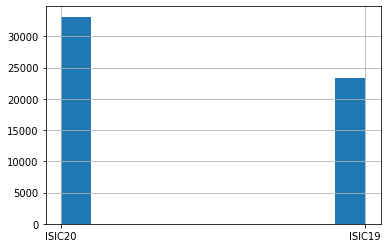

In [48]:
print(combined_df['source'].value_counts())
combined_df['source'].hist()

0    51651
1     4732
Name: target, dtype: int64


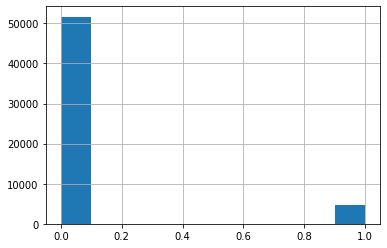

In [51]:
print(combined_df["target"].value_counts())
combined_df["target"].hist()